In [28]:
# imports
import numpy as np
import pandas as pd

# modelling
from sklearn import datasets
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, classification_report, auc, f1_score
from sklearn.model_selection import train_test_split

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

c:\Program Files\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset split: 56000 train rows 56000 label rows
Dataset split: 14000 test rows 14000 label rows


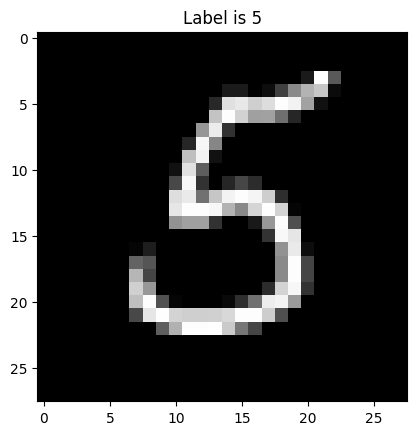

In [2]:
# Initialize
mnist = datasets.fetch_openml("mnist_784")
X, y = mnist.data, mnist.target

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# digits = load_digits()
print(f"Dataset split: {len(x_train)} train rows",
          f"{len(y_train)} label rows")

print(f"Dataset split: {len(x_test)} test rows",
          f"{len(y_test)} label rows")

point = np.array(x_train.iloc[0], dtype='uint8')
point = point.reshape((28, 28))

plt.title('Label is {label}'.format(label=y_train.iloc[0]))
plt.imshow(point, cmap='gray')
plt.show()

In [3]:
# Add outliers
print(x_train.shape)
print(x_test.shape)

(56000, 784)
(14000, 784)


In [4]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

# convert labels to integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [5]:
# Create and fit a Local Outlier Factor model
model = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
model.fit(x_train)

LocalOutlierFactor(contamination=0.1)

In [18]:
y_pred = model.fit_predict(x_test)

# Calculate anomaly scores
anomaly_scores = -model.negative_outlier_factor_

In [19]:
# Get the indexes of anomalies
anomaly_indexes = np.where(y_pred == -1)[0]

In [20]:
# Print the number of anomalies and accuracy
print("Number of anomalies:", len(anomaly_indexes))
print("Accuracy:", accuracy_score(y_test, (y_pred == 1)))

Number of anomalies: 1400
Accuracy: 0.10157142857142858


In [21]:
# Print the indexes of anomalies
print("Indexes of Anomalies:")
print(anomaly_indexes)

Indexes of Anomalies:
[    5    10    17 ... 13982 13992 13999]


In [22]:
# Print the classification report
report = classification_report(y_test, (y_pred == -1), target_names=[str(i) for i in range(10)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.97      0.19      1343
           1       0.16      0.14      0.15      1600
           2       0.00      0.00      0.00      1380
           3       0.00      0.00      0.00      1433
           4       0.00      0.00      0.00      1295
           5       0.00      0.00      0.00      1273
           6       0.00      0.00      0.00      1396
           7       0.00      0.00      0.00      1503
           8       0.00      0.00      0.00      1357
           9       0.00      0.00      0.00      1420

    accuracy                           0.11     14000
   macro avg       0.03      0.11      0.03     14000
weighted avg       0.03      0.11      0.03     14000



c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Consider anomalies as the positive class
y_test_positive = (y_test == -1)

# Calculate precision-recall curve and AUC-PR
precision, recall, _ = precision_recall_curve(y_test_positive, anomaly_scores)
auc_pr = auc(recall, precision)

print("AUC-PR (Area Under the Precision-Recall Curve):", auc_pr)

AUC-PR (Area Under the Precision-Recall Curve): 0.5


c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [29]:
# Calculate precision, recall, and F1-score for anomaly detection
precision = precision_score(y_test, (y_pred == -1), average='weighted')
recall = recall_score(y_test, (y_pred == -1), average='weighted')
f1 = f1_score(y_test, (y_pred == -1), average='weighted')

c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.028234285714285715
Recall: 0.10864285714285714
F1-Score: 0.03497595311523448


In [31]:
# Save the anomaly indexes to a file
with open("anomaly_indexes.txt", "w") as file:
    for idx in anomaly_indexes:
        file.write(str(idx) + "\n")

In [32]:
# Reshape the test data for plotting
x_test_reshaped = x_test.values.reshape(-1, 28, 28)

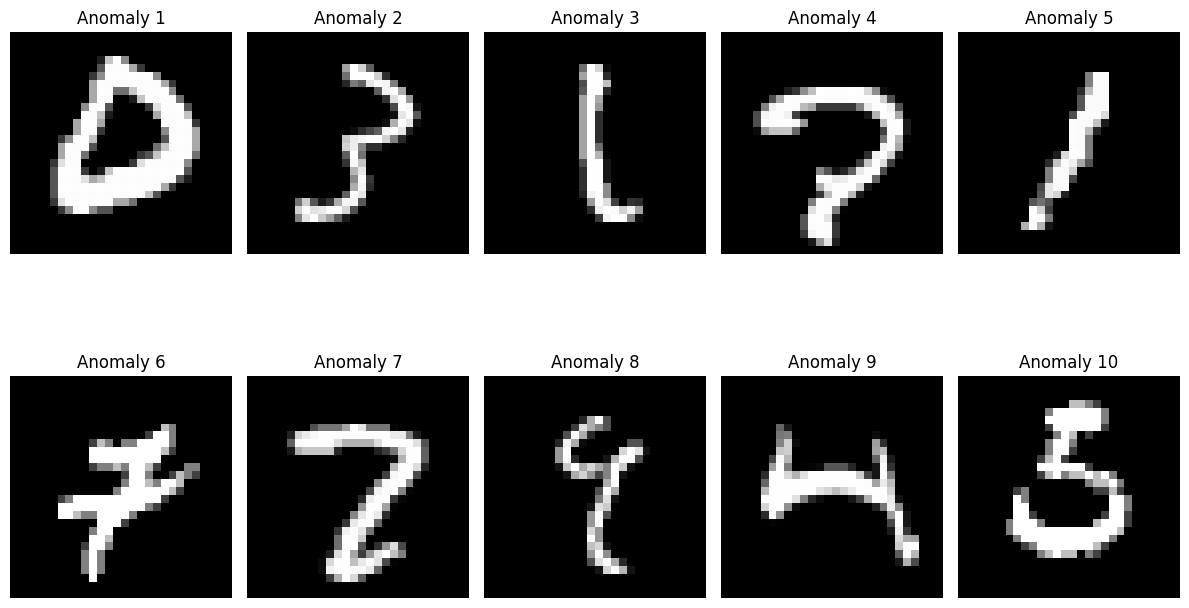

In [33]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomalies
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_reshaped[idx], cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

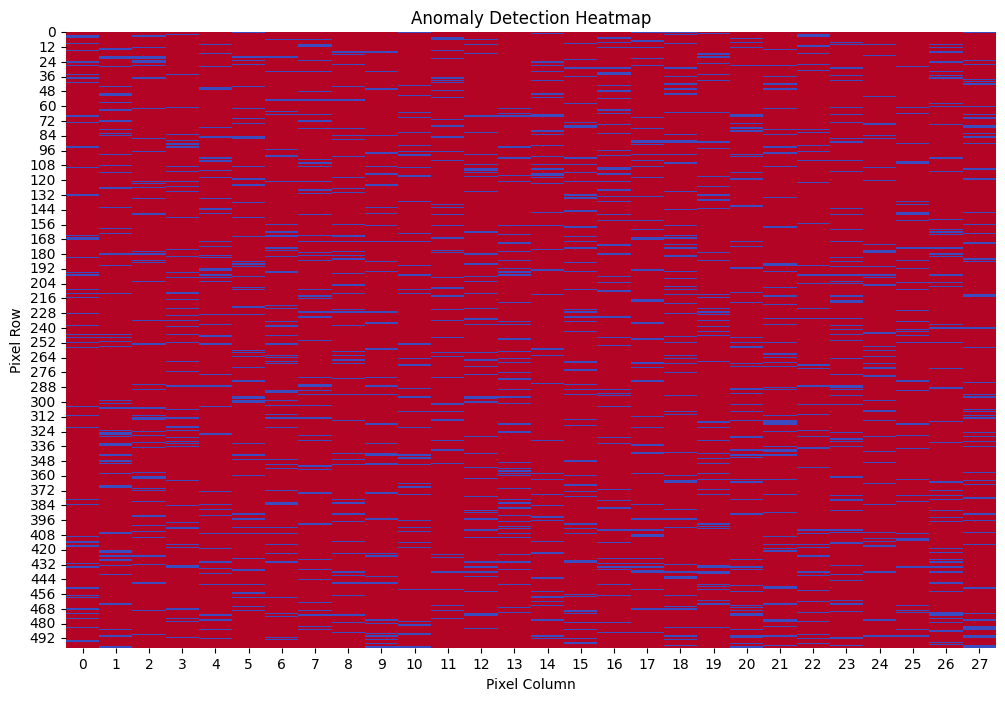

In [34]:
# Create a heatmap of anomalies
plt.figure(figsize=(12, 8))
sns.heatmap(y_pred.reshape(-1, 28), cmap='coolwarm', cbar=False)
plt.title('Anomaly Detection Heatmap')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

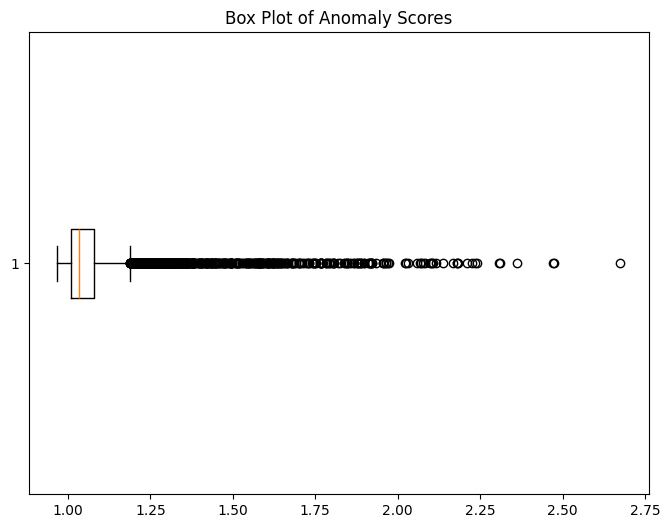

In [36]:
# Create a box plot of anomaly scores
plt.figure(figsize=(8, 6))
plt.boxplot(anomaly_scores, vert=False)
plt.title('Box Plot of Anomaly Scores')
plt.show()